# Time Series Analysis 
## Website Traffic Data

This notebook outlines timeseries analysis for a website's daily traffic data using python libraries/packages. It begins with exploratory analysis followed by forecasting using ARMA, ARIMA and exponential smoothening.

##### Data Courtesy : [OpenMV.net](http://openmv.net/info/website-traffic)

## 1.0 Exploratory Analysis

In this section we will understand the dataset by looking into its various attributes, deriving attributes and even visualizing patterns if any.

We may also need to peform dataset cleanup and standardization or this can be taken up as prerequisite before exploratory analysis. Since we have a relatively smaller dataset with limited attributes, a separate ETL step would be an overhead.


We begin by Importing necessary packages.

In [2]:
# Imports

# Pandas and Numpy for data structures and util fucntions
import numpy as np
import pandas as pd

# Statsmodels functions
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Matplot for functions
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 Dataset basics
 * Load the dataset
 * Check the column data types
 * View a few sample rows

In [3]:
# load dataset
input_df = pd.read_csv(r'data\website-traffic.csv')
print input_df.columns
print input_df.dtypes
print input_df.head()

Index([u'DayOfWeek', u'MonthDay', u'Year', u'Visits'], dtype='object')
DayOfWeek    object
MonthDay     object
Year          int64
Visits        int64
dtype: object
   DayOfWeek MonthDay  Year  Visits
0     Monday   June 1  2009      27
1    Tuesday   June 2  2009      31
2  Wednesday   June 3  2009      38
3   Thursday   June 4  2009      38
4     Friday   June 5  2009      31


### 1.2 Adding additional Attributes
Creating a new column as there isn't any date column in the dataset. We may choose to drop columns *DayOFWeek, MonthDay and Year* to save space. Since this is a very small dataset, it is ok to keep these!

In [4]:
input_df['date_of_visit'] = input_df.MonthDay.str.cat(input_df.Year.astype(str), sep=' ')
input_df['date_of_visit']  = pd.to_datetime(input_df['date_of_visit'])
print "DataTypes\n\n",input_df.dtypes
print "\nSample output\n\n",input_df.head()

DataTypes

DayOfWeek                object
MonthDay                 object
Year                      int64
Visits                    int64
date_of_visit    datetime64[ns]
dtype: object

Sample output

   DayOfWeek MonthDay  Year  Visits date_of_visit
0     Monday   June 1  2009      27    2009-06-01
1    Tuesday   June 2  2009      31    2009-06-02
2  Wednesday   June 3  2009      38    2009-06-03
3   Thursday   June 4  2009      38    2009-06-04
4     Friday   June 5  2009      31    2009-06-05


### 1.3 Sample Plot
Let us now plot the visits per day and visualize the visit pattern.

In total we have 214 days worth of visit data starting from June 01 2009

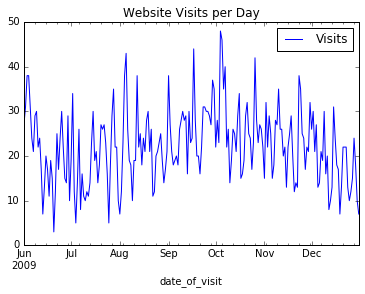

In [5]:
# plot visits data
#input_df['Visits'].plot()

# plot with dates on x-axis
input_df.plot(x='date_of_visit',y='Visits', title= "Website Visits per Day")

### 1.4 Visits in Detail

Let us now understand basic stats related to visits_per_day

In [6]:
print "Minimum Visits::",input_df.Visits.min()
print "Maximum Visits::",input_df.Visits.max()
print "Average Visits::",input_df.Visits.mean()
print "Median Visits::",input_df.Visits.median()

Minimum Visits:: 3
Maximum Visits:: 48
Average Visits:: 22.2336448598
Median Visits:: 22.0


Let us see how visits distribute along with *DayOfWeek*

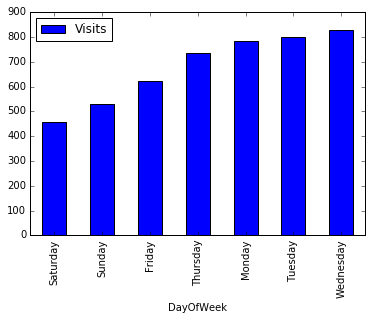

In [7]:
input_df[['DayOfWeek','Visits']].groupby('DayOfWeek').sum().sort_values('Visits').plot.bar()

The above plot shows that weekdays see more visitors as compared to weekends with peak visits during mid of the week as *Wednesday*.

Let us now see how the values of visits are distributed in general

In [8]:
print "Visit stats\n\n",input_df.Visits.describe()

Visit stats

count    214.000000
mean      22.233645
std        8.331826
min        3.000000
25%       16.250000
50%       22.000000
75%       27.750000
max       48.000000
Name: Visits, dtype: float64


The above information, particularly quartiles, show that the visits might be following a normal distribution centered at mean 22.233. Let us see if this is the case actually.

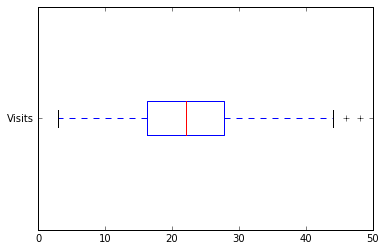

In [9]:
input_df.Visits.plot.box(vert=False)

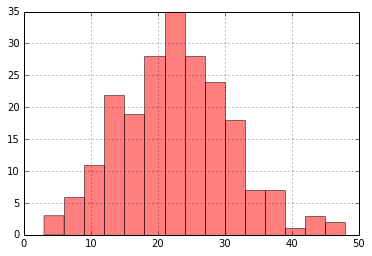

In [10]:
input_df.Visits.hist(color='red', alpha=0.5,bins=15)

The above two plot confirm our hunch about normality, though its slightly skewed towards 0 and tailing towards 50. The boxplot also points out that other than a couple of outliers beyond the max value, the visit distribution is more or less normal.

## 2.0 Time Series Analysis

Now that we have explored the dataset, we can begin our anaylsis from a time series point of view. In this section we will identify different characteristics of visits per day as a function of time (as opposed to an *iid* random variable). 

### 2.1 Components of Visit Series

To begin with, we will replot the *Visits* with *date_of_visit* on x-axis (as we did in the previous section).

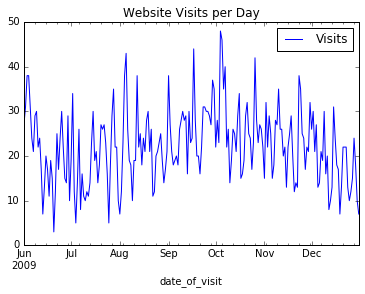

In [11]:
# plot with dates on x-axis
input_df.plot(x='date_of_visit',y='Visits', title= "Website Visits per Day")

Each time varying function/series can be split into 3 major building blocks:
 * Trend
 * Seasonality
 * Residual Signal

We now decompose our visits time series into its three consitituents as follows.

In [12]:
# extract visits as series from the dataframe
ts_visits = pd.Series(input_df.Visits.values
                      ,index=pd.date_range(
                                            input_df.date_of_visit.min()
                                            , input_df.date_of_visit.max()
                                            , freq='D')
                     )

print "Frequency of series object::",ts_visits.index.freq

# This is a workaround which would be fixed in version 0.7 onwards.
# For now pass a numpy array with specific frequency as statsmodel isnt able to use pandas fre
decomposition = seasonal_decompose(ts_visits.values,freq=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

Frequency of series object:: <Day>


### 2.2 Plotting the decomposition

* Overall split of the signal

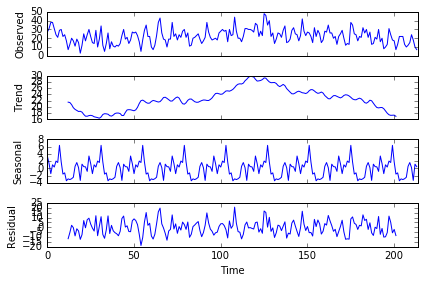

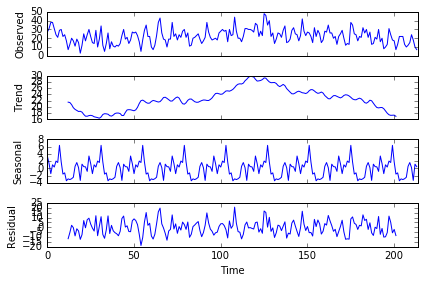

In [13]:
decomposition.plot()

* Trend based on time

This plot shows an upward trend till October which then turns into a downward trend as we move towards end of the year

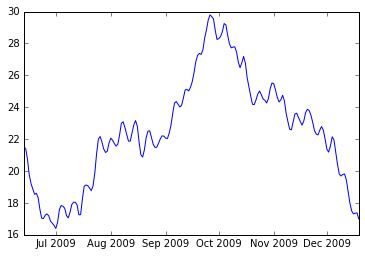

In [14]:
plt.plot(ts_visits.index.values,trend)

* Seasonality based on time

This plot shows a monthly seasonality with similar peaks towards end of every month

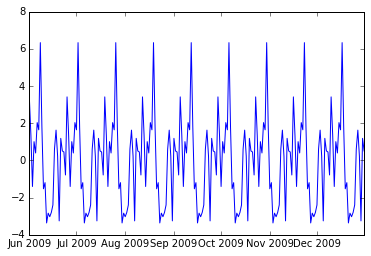

In [15]:
plt.plot(ts_visits.index.values,seasonal)

### 2.3 Its Time to Model some Time Series

We begin with first checking if the series is **stationary** or not. Incase it is not, we apply methods like *detrending, differencing, etc.* to stationarize our series. 

** Stationary Series **

_Mention Details about stationary series here_

** Visually Checking for Stationarity**

We will visually examine if our mean and stand deviation are constant throughout the series or not. For a non-stationary series these attributes will vary with time.
We utilise *pandas* utilities to calculate these rolling measures.

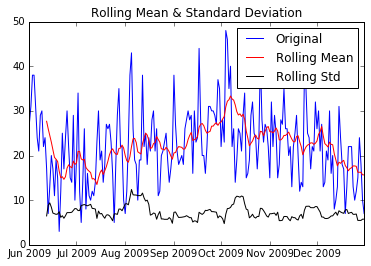

In [16]:
def plot_rolling_stats(ts):
    rolling_mean = ts.rolling(window=12,center=False).mean()
    rolling_std = ts.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

plot_rolling_stats(ts_visits)

In [17]:
def ad_fuller_test(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

ad_fuller_test(ts_visits)

Test Statistic                  -2.521668
p-value                          0.110291
#Lags Used                       6.000000
Number of Observations Used    207.000000
Critical Value (5%)             -2.875606
Critical Value (1%)             -3.462342
Critical Value (10%)            -2.574267
dtype: float64


** Understanding the Results**

The _Test Statistic_'s value is greater than all the critical values (consider signed values and not absolute ones). Thus we conclude that the series is not **stationary**.

### 2.4 Stationar-izing Series

Common methods to stationarize time series :
 * Transformation : log, square root, cube root, etc.   
 * Moving Average
 * Exponential Weighted Moving Average
 * Shift/Differencing
 
 
The following code snippets can be executed to see the above mentioned methods in action.

```python
# log transformation
ts_visits_log = np.log(ts_visits)
plt.plot(ts_visits_log)

# Moving Average
moving_avg = ts_visits_log.rolling(window=12,center=False).mean()
plt.plot(ts_visits_log)
plt.plot(moving_avg, color='red')

ts_log_moving_avg_diff = ts_visits_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
ad_fuller_test(ts_log_moving_avg_diff)


# Exponential Weighted Moving Average
expwighted_avg = ts_visits_log.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
plt.plot(ts_visits_log)
plt.plot(expwighted_avg, color='red')

ts_log_ewma_diff = ts_visits_log - expwighted_avg
ts_log_ewma_diff.dropna(inplace=True)
ad_fuller_test(ts_log_ewma_diff)

# Shift/Differncing
ts_log_diff = ts_visits_log - ts_log.shift()
plt.plot(ts_log_diff)

ts_log_diff.dropna(inplace=True)
ad_fuller_test(ts_log_diff)
```

** Back to Decomposition **

We decomposed the original series into its constituent trend, seasonality and residual signal. Let us revisit the decomposed series and see if the residual signal is stationary or not.

(190L,)
Test Statistic                -6.912073e+00
p-value                        1.205235e-09
#Lags Used                     1.100000e+01
Number of Observations Used    1.780000e+02
Critical Value (5%)           -2.877918e+00
Critical Value (1%)           -3.467632e+00
Critical Value (10%)          -2.575501e+00
dtype: float64


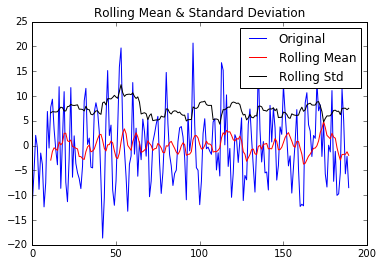

In [18]:
residual_dash = residual[~np.isnan(residual)]
print residual_dash.shape
ad_fuller_test(residual_dash)

plot_rolling_stats(pd.DataFrame(data=residual_dash))

The above results show that the _Test Statistic_ is lower than **1%** _Critical Value_ . Thus we can say that the series is stationary with very high confidence.

### 2.5 Forecasting

Now that we understand what stationarity means and have seen a few methods to convert non-stationary ones into stationary series, our next goal is to forecast future values. The statsmodels package has a number of utilities to perform forecasting. But before that we will quickly go through a few concepts.

** Auto Regression (AR) **

-- Mention details here


** Moving Average (MA) **

-- Mention details here

** Auto Regression Integrated Moving Average (ARIMA) **

-- Mention details here


** Holt's Exponential Smoothening (HES) **

-- Mention details here



** Auto Correlation Function (ACF) **

-- Mention details here


** Partial Auto Correlation Function (PACF) **

-- Mention details here


Test Statistic                -1.434192e+01
p-value                        1.056524e-26
#Lags Used                     5.000000e+00
Number of Observations Used    2.070000e+02
Critical Value (5%)           -2.875606e+00
Critical Value (1%)           -3.462342e+00
Critical Value (10%)          -2.574267e+00
dtype: float64


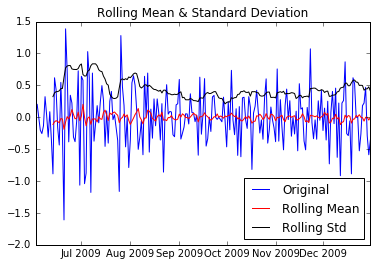

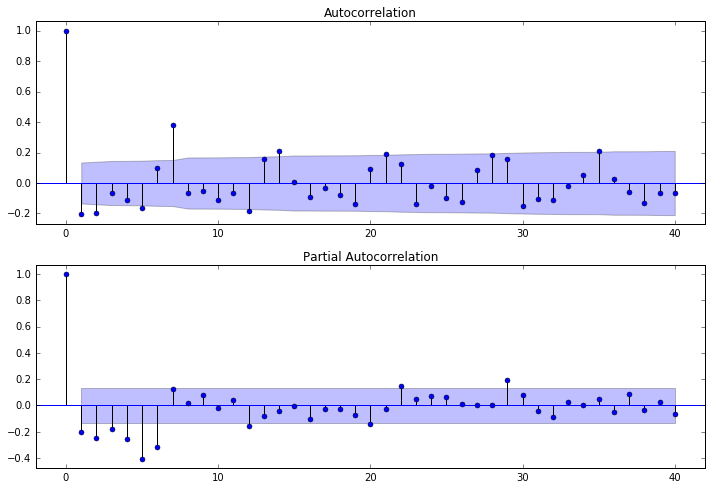

In [20]:
ts_visits_log = np.log(ts_visits)
ts_visits_log_shift = ts_visits_log - ts_visits_log.shift()
ts_visits_log_shift = ts_visits_log_shift[~np.isnan(ts_visits_log_shift)]
ad_fuller_test(ts_visits_log_shift)
plot_rolling_stats(ts_visits_log_shift)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_visits_log_shift.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_visits_log_shift, lags=40, ax=ax2)

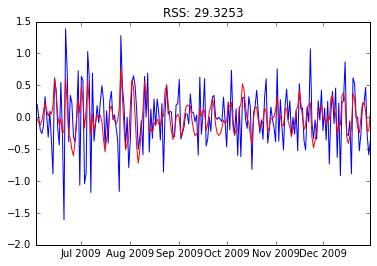

In [37]:
model = ARIMA(ts_visits_log, order=(2, 1, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_visits_log_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_visits_log_shift)**2))

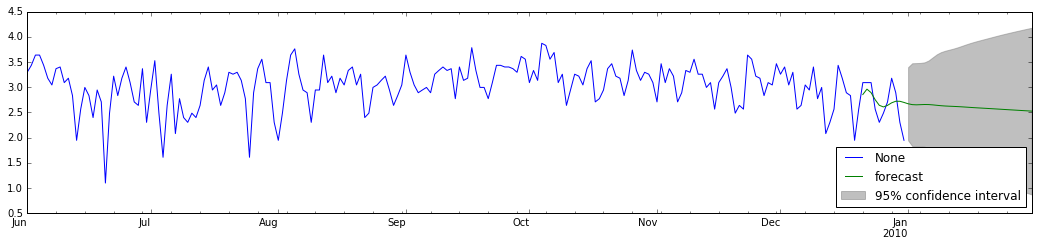

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  213
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -91.617
Method:                       css-mle   S.D. of innovations              0.371
Date:                Thu, 22 Sep 2016   AIC                            195.233
Time:                        09:13:07   BIC                            215.401
Sample:                    06-02-2009   HQIC                           203.384
                         - 12-31-2009                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.010     -0.518      0.605      -0.024       0.014
ar.L1.D.y      1.0601      0.087     12.188      0.000       0.890       1.231
ar.L2.D.y     -0.6180      0.069     -8.932      0.0

In [38]:
fig, ax = plt.subplots(figsize=(18, 4))
fig.autofmt_xdate()
ax = ts_visits_log.ix[:].plot(ax=ax)
fig = results_AR.plot_predict('2009-12-21', '2010-01-31', dynamic=True,ax=ax,plot_insample=False)
plt.show()

In [124]:
results_AR.params

const       -0.004949
ar.L1.D.y    1.060123
ar.L2.D.y   -0.618046
ma.L1.D.y   -1.534972
ma.L2.D.y    0.744312
dtype: float64

In [125]:
results_AR.pvalues


const        6.050351e-01
ar.L1.D.y    3.863320e-26
ar.L2.D.y    2.255819e-16
ma.L1.D.y    1.371113e-49
ma.L2.D.y    2.191771e-17
dtype: float64